In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Large
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import pickle

In [2]:
from google.colab import drive,files
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def check_device():
    tf_devices = tf.config.list_physical_devices('GPU')
    if tf_devices:
        print('TensorFlow can access GPU:')
        for device in tf_devices:
            print(device)
    else:
        print('TensorFlow is using CPU.')
check_device()

TensorFlow can access GPU:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


DATASET_PATH = './dataset/raw'

## Dataset Loading,Showing sample images from each class and Verification Functions

In [6]:
# Cell 5: Dataset Loading and Verification Functions
def show_samples_per_class(X, y, label_encoder, split_name, samples_per_class=3):
    unique_classes = np.unique(y)
    n_classes = len(unique_classes)

    plt.figure(figsize=(15, 3 * n_classes))

    for idx, class_idx in enumerate(unique_classes):
        # Get indices for current class
        class_indices = np.where(y == class_idx)[0]

        # Randomly sample from this class
        sample_indices = np.random.choice(
            class_indices,
            min(samples_per_class, len(class_indices)),
            replace=False
        )

        for j, sample_idx in enumerate(sample_indices):
            plt.subplot(n_classes, samples_per_class, idx * samples_per_class + j + 1)
            plt.imshow(X[sample_idx].astype('uint8'))
            plt.title(f'{split_name}\n{label_encoder.inverse_transform([class_idx])[0]}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

def load_and_verify_dataset(folder, img_size=(224, 224), test_size=0.2, val_size=0.2, random_state=42):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder))

    print("Loading dataset...")
    class_counts = {class_name: 0 for class_name in class_names}

    # Progress tracking
    total_files = sum([len(os.listdir(os.path.join(folder, class_name))) for class_name in class_names])
    processed_files = 0

    for class_name in class_names:
        class_path = os.path.join(folder, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
                img = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img)
                labels.append(class_name)
                class_counts[class_name] += 1

                processed_files += 1
                if processed_files % 100 == 0:
                    print(f"Processed {processed_files}/{total_files} images")

            except Exception as e:
                print(f"Error loading image {img_path}: {str(e)}")
                continue

    X = np.array(images)
    y = np.array(labels)

    # Print initial class distribution
    print("\nInitial class distribution:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images ({count/len(y)*100:.2f}%)")

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Perform splits
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y_encoded,
        test_size=test_size,
        random_state=random_state,
        stratify=y_encoded
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=val_size,
        random_state=random_state,
        stratify=y_temp
    )

    # Verify stratification
    def print_split_distribution(y, split_name):
        unique, counts = np.unique(y, return_counts=True)
        total = len(y)
        print(f"\n{split_name} set distribution:")
        for class_idx, count in zip(unique, counts):
            class_name = label_encoder.inverse_transform([class_idx])[0]
            percentage = (count/total) * 100
            print(f"{class_name}: {count} images ({percentage:.2f}%)")

    print("\nVerifying split distributions...")
    print_split_distribution(y_train, "Training")
    print_split_distribution(y_val, "Validation")
    print_split_distribution(y_test, "Test")

    # Show sample images from each split
    print("\nShowing sample images from each class in each split...")
    show_samples_per_class(X_train, y_train, label_encoder, "Train")
    show_samples_per_class(X_val, y_val, label_encoder, "Validation")
    show_samples_per_class(X_test, y_test, label_encoder, "Test")

    return X_train, X_val, X_test, y_train, y_val, y_test, label_encoder

Loading dataset...
Processed 100/3000 images
Processed 200/3000 images
Processed 300/3000 images
Processed 400/3000 images
Processed 500/3000 images
Processed 600/3000 images
Processed 700/3000 images
Processed 800/3000 images
Processed 900/3000 images
Processed 1000/3000 images
Processed 1100/3000 images
Processed 1200/3000 images
Processed 1300/3000 images
Processed 1400/3000 images
Processed 1500/3000 images
Processed 1600/3000 images
Processed 1700/3000 images
Processed 1800/3000 images
Processed 1900/3000 images
Processed 2000/3000 images
Processed 2100/3000 images
Processed 2200/3000 images
Processed 2300/3000 images
Processed 2400/3000 images
Processed 2500/3000 images
Processed 2600/3000 images
Processed 2700/3000 images
Processed 2800/3000 images
Processed 2900/3000 images
Processed 3000/3000 images

Initial class distribution:
Angus: 1000 images (33.33%)
Hereford: 1000 images (33.33%)
Holstein: 1000 images (33.33%)

Verifying split distributions...

Training set distribution:

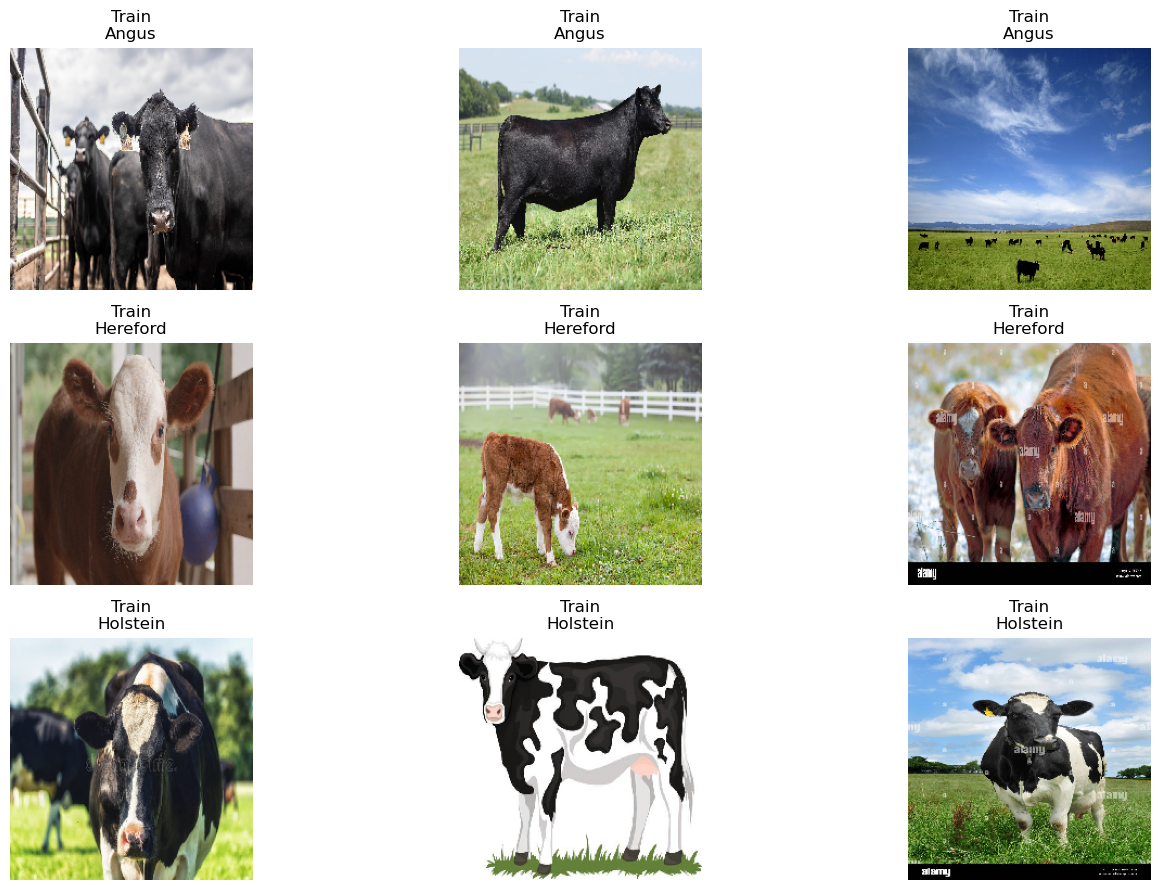

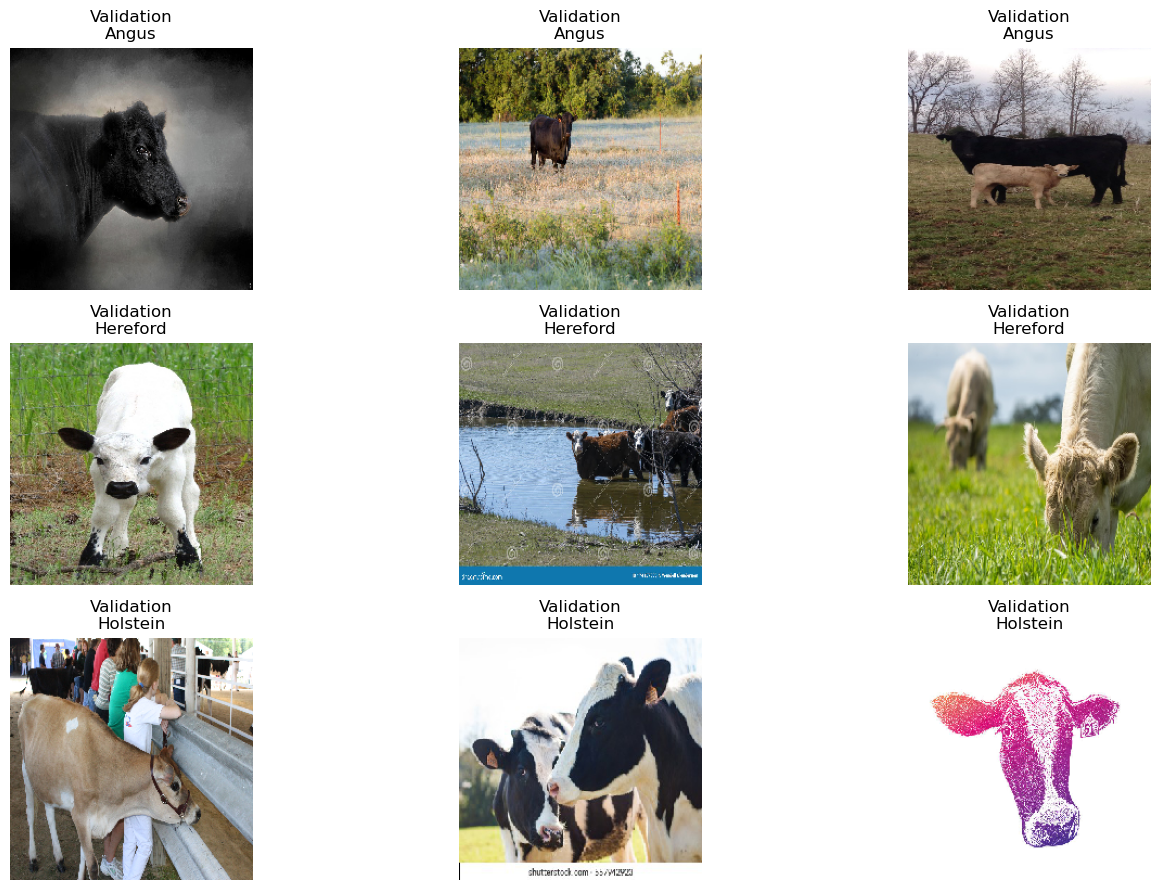

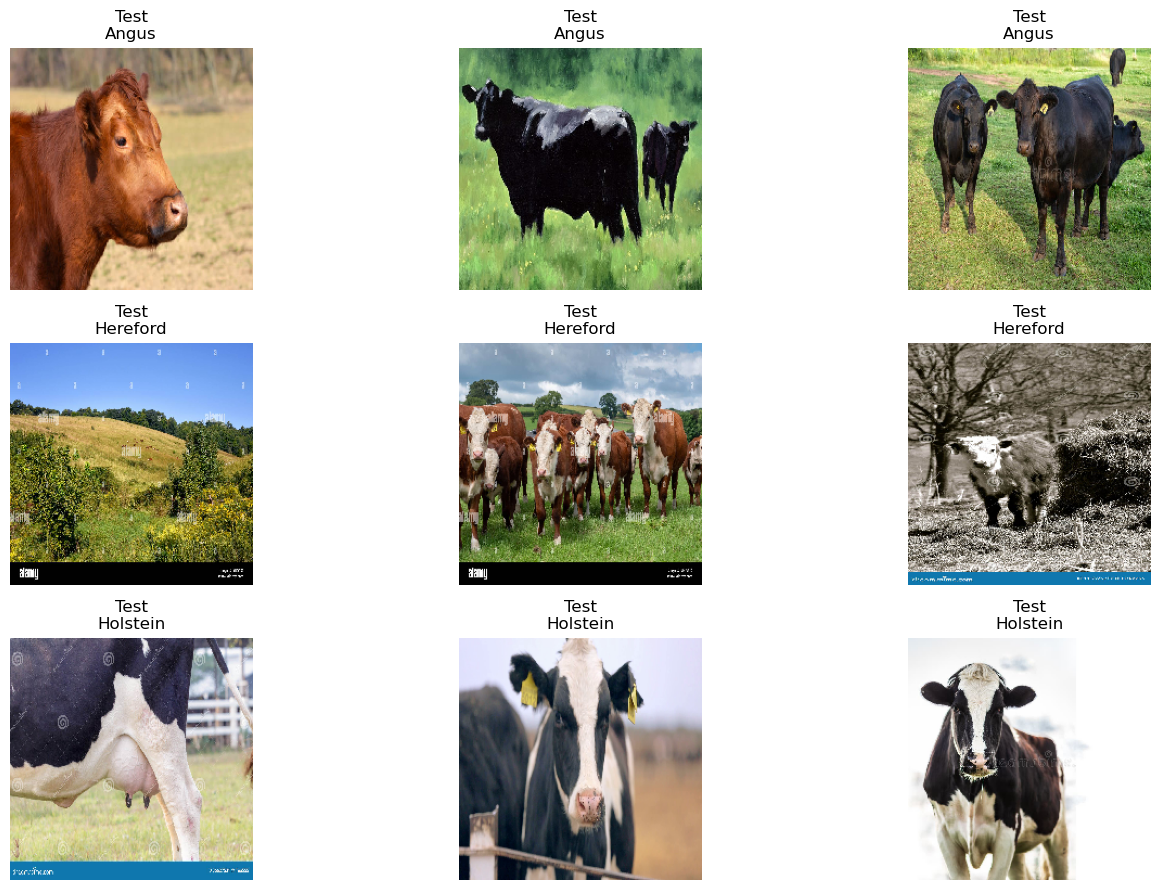

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = load_and_verify_dataset(DATASET_PATH)

## Data Augmentation Setup

In [9]:
data_gen_args = dict(
    rescale=1./255,
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    horizontal_flip=True,
    vertical_flip=False,  
    zoom_range=0.2,  
    brightness_range=[0.8, 1.2],  
    fill_mode='nearest'  
)

train_data_gen = ImageDataGenerator(**data_gen_args)
val_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_data_gen.flow(X_train, y_train, batch_size=32)
val_generator = val_data_gen.flow(X_val, y_val, batch_size=32)
test_generator = test_data_gen.flow(X_test, y_test, batch_size=32)

## Visualizing augmented training images

Visualizing augmented training images...


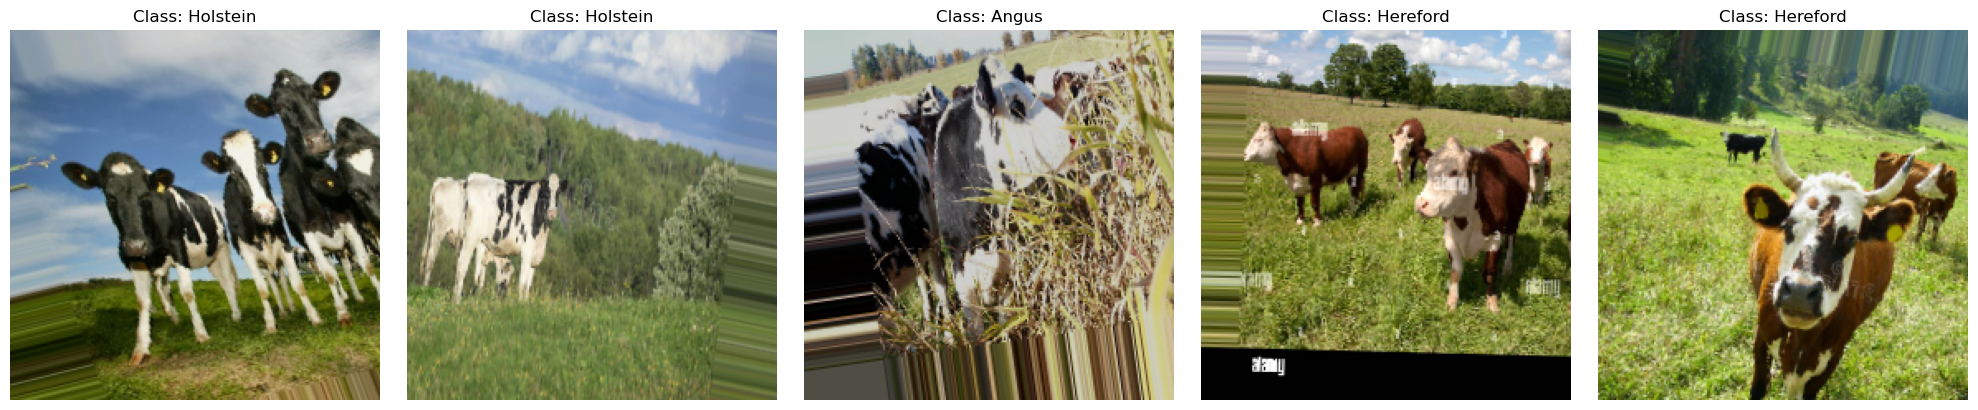

In [10]:
def visualize_augmented_images(generator, num_images=5):
    batch_images, batch_labels = next(generator)

    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(batch_images[i])
       
        class_name = label_encoder.inverse_transform([batch_labels[i]])[0]
        plt.title(f"Class: {class_name}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Create generators with the correct label format
train_generator = train_data_gen.flow(
    X_train,
    y_train,  
    batch_size=32,
    shuffle=True
)
val_generator = val_data_gen.flow(
    X_val,
    y_val,
    batch_size=32,
    shuffle=False
)
test_generator = test_data_gen.flow(
    X_test,
    y_test,
    batch_size=32,
    shuffle=False
)

print("Visualizing augmented training images...")
visualize_augmented_images(train_generator)

## Model Building

In [10]:
def build_model(base_model, num_classes, dropout_rate=0.5):
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)  # Added
    x = layers.Dropout(dropout_rate)(x)  # Added
    x = layers.Dense(256, activation='relu')(x)  # Added
    x = layers.Dropout(dropout_rate)(x)  # Added
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

num_classes = len(label_encoder.classes_)

models_dict = {
    'ResNet50': build_model(ResNet50(weights='imagenet', include_top=False), num_classes),
    'DenseNet121': build_model(DenseNet121(weights='imagenet', include_top=False), num_classes),
    'MobileNetV3': build_model(MobileNetV3Large(weights='imagenet', include_top=False), num_classes)
}

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
results={}

def train_and_save_model(model, model_name, train_generator, val_generator, test_generator, y_test, label_encoder, epochs=50, lr=0.001):
    optimizer = optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Add callbacks
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )

    start_time = time.time()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[reduce_lr],
        verbose=1
    )

    training_time = time.time() - start_time

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Access true labels from y_test
    true_classes = y_test

    # Calculate mAP
    mAP = np.mean([
        np.mean(np.array(predictions)[:, i] * (true_classes == i))
        for i in range(len(label_encoder.classes_))
    ])

    # Save the results
    results = {
        'model': model,
        'history': history.history,
        'training_time': training_time,
        'test_accuracy': test_accuracy,
        'mAP': mAP
    }

    print(f"{model_name} Results:")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"mAP: {mAP:.4f}")

    # Save model and results
    model_save_path = f"/content/{model_name}_model.h5"
    model.save(model_save_path)

    results_save_path = f"/content/{model_name}_results.pkl"
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

    files.download(model_save_path)
    files.download(results_save_path)


## Train MobileNetV3

In [14]:
print("\nTraining MobileNetV3...")
mobilenet_model = build_model(MobileNetV3Large(weights='imagenet', include_top=False), num_classes)
train_and_save_model(mobilenet_model, 'MobileNetV3', train_generator, val_generator, test_generator, y_test, label_encoder)



Training MobileNetV3...


/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 510ms/step - accuracy: 0.3467 - loss: 1.2188 - val_accuracy: 0.4292 - val_loss: 1.0848 - learning_rate: 0.0010
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 430ms/step - accuracy: 0.3577 - loss: 1.0998 - val_accuracy: 0.4417 - val_loss: 1.0622 - learning_rate: 0.0010
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 393ms/step - accuracy: 0.4041 - loss: 1.0767 - val_accuracy: 0.4396 - val_loss: 1.0432 - learning_rate: 0.0010
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 384ms/step - accuracy: 0.3999 - loss: 1.0693 - val_accuracy: 0.4563 - val_loss: 1.0262 - learning_rate: 0.0010
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 385ms/step - accuracy: 0.4003 - loss: 1.0629 - val_accuracy: 0.4625 - val_loss: 1.0251 - learning_rate: 0.0010
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 405ms/step - accuracy: 0.4151 - loss: 1.0543 - val_accuracy: 0.4729 - val_loss: 1.0472 - learning_rate: 0.0010
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 398ms/step - accuracy: 0.4226 - loss: 1.

MobileNetV3 Results:
Training Time: 1641.00 seconds
Test Accuracy: 0.5150
mAP: 0.1371


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Training ResNet50

In [15]:
print("\nTraining ResNet50...")
resnet_model = build_model(ResNet50(weights='imagenet', include_top=False), num_classes)
train_and_save_model(resnet_model, 'ResNet50', train_generator, val_generator, test_generator, y_test, label_encoder)



Training ResNet50...
Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 45s 498ms/step - accuracy: 0.3148 - loss: 1.3367 - val_accuracy: 0.4333 - val_loss: 1.0587 - learning_rate: 0.0010
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 409ms/step - accuracy: 0.3876 - loss: 1.0903 - val_accuracy: 0.4750 - val_loss: 1.0121 - learning_rate: 0.0010
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 407ms/step - accuracy: 0.4331 - loss: 1.0680 - val_accuracy: 0.5125 - val_loss: 0.9991 - learning_rate: 0.0010
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 401ms/step - accuracy: 0.4762 - loss: 1.0397 - val_accuracy: 0.5042 - val_loss: 0.9844 - learning_rate: 0.0010
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 407ms/step - accuracy: 0.4543 - loss: 1.0243 - val_accuracy: 0.4896 - val_loss: 0.9858 - learning_rate: 0.0010
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 412ms/step - accuracy: 0.4412 - loss: 1.0463 - val_accuracy: 0.5063 - val_loss: 0.9732 - learning_rate: 0.0010
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 426ms/step - accur

ResNet50 Results:
Training Time: 1703.30 seconds
Test Accuracy: 0.5383
mAP: 0.1364


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Training DenseNet121

In [16]:
print("\nTraining DenseNet121...")
densenet_model = build_model(DenseNet121(weights='imagenet', include_top=False), num_classes)
train_and_save_model(densenet_model, 'DenseNet121', train_generator, val_generator, test_generator, y_test, label_encoder)



Training DenseNet121...
Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 69s 594ms/step - accuracy: 0.5454 - loss: 1.1848 - val_accuracy: 0.8292 - val_loss: 0.4418 - learning_rate: 0.0010
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 437ms/step - accuracy: 0.7787 - loss: 0.5922 - val_accuracy: 0.8729 - val_loss: 0.3731 - learning_rate: 0.0010
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 433ms/step - accuracy: 0.8148 - loss: 0.4665 - val_accuracy: 0.8792 - val_loss: 0.3684 - learning_rate: 0.0010
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 436ms/step - accuracy: 0.8178 - loss: 0.4693 - val_accuracy: 0.8792 - val_loss: 0.3656 - learning_rate: 0.0010
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 437ms/step - accuracy: 0.8400 - loss: 0.4270 - val_accuracy: 0.8687 - val_loss: 0.3661 - learning_rate: 0.0010
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 437ms/step - accuracy: 0.8454 - loss: 0.3960 - val_accuracy: 0.8958 - val_loss: 0.3294 - learning_rate: 0.0010
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 424ms/step - ac

DenseNet121 Results:
Training Time: 1776.10 seconds
Test Accuracy: 0.8717
mAP: 0.2788


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Accuracy curves and  Loss curves of every model

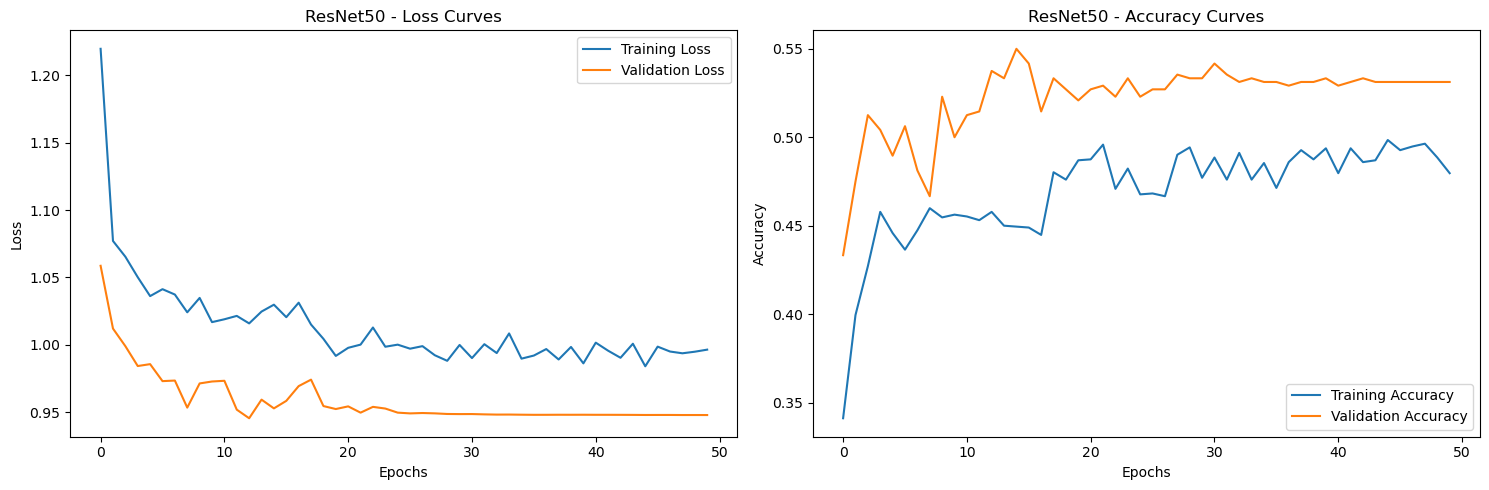

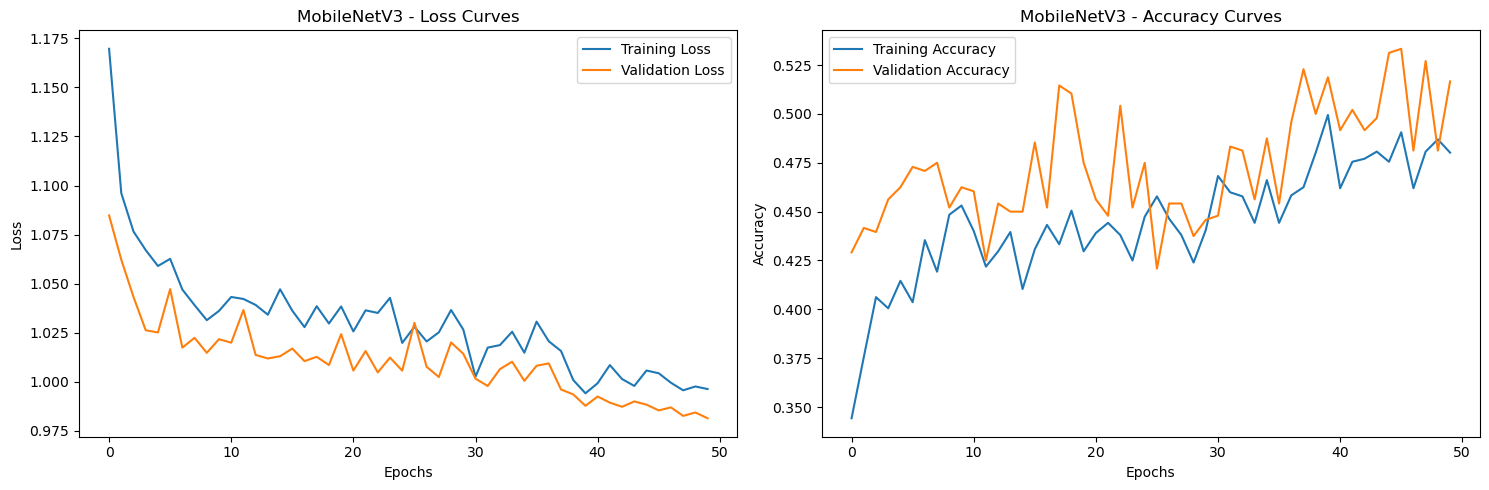

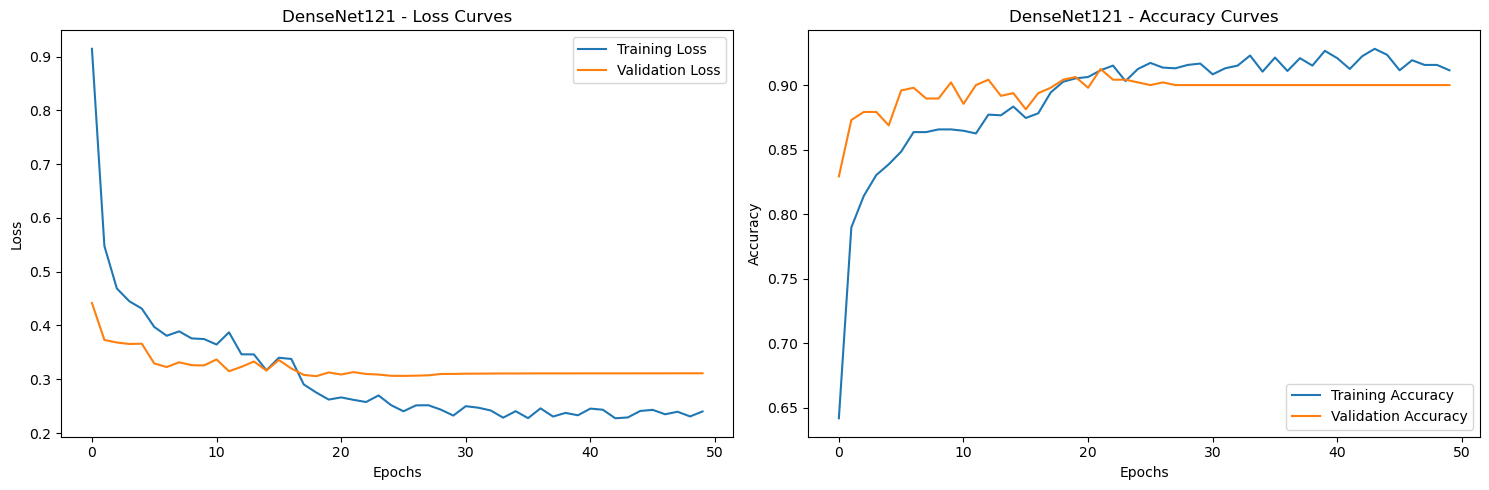

In [12]:
def plot_training_curves(results_data, title):
    history = results_data['history']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss curves
    ax1.plot(history['loss'], label='Training Loss') # Changed line
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{title} - Loss Curves')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy curves
    ax2.plot(history['accuracy'], label='Training Accuracy') # Changed line
    ax2.plot(history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title(f'{title} - Accuracy Curves')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()
    # File paths
mobilenet_results_path = "./models/MobilenetV3/MobileNetV3_results.pkl"
resnet_results_path = "./models/Resnet50/ResNet50_results.pkl"
densenet_results_path = "./models/Densenet121/DenseNet121_results.pkl"

results_files = {
    "ResNet50": resnet_results_path,
    "MobileNetV3": mobilenet_results_path,
    "DenseNet121": densenet_results_path
}
    # print(result)



for model_name, file_path in results_files.items():
    if not os.path.exists(file_path):
        print(f"Error: File not found - {file_path}")
        continue
    
    with open(file_path, 'rb') as f:
        results_data = pickle.load(f)
    
    plot_training_curves(results_data, model_name)

## confusion matrix,Classification Report and Map calc


Evaluating ResNet50...
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step 


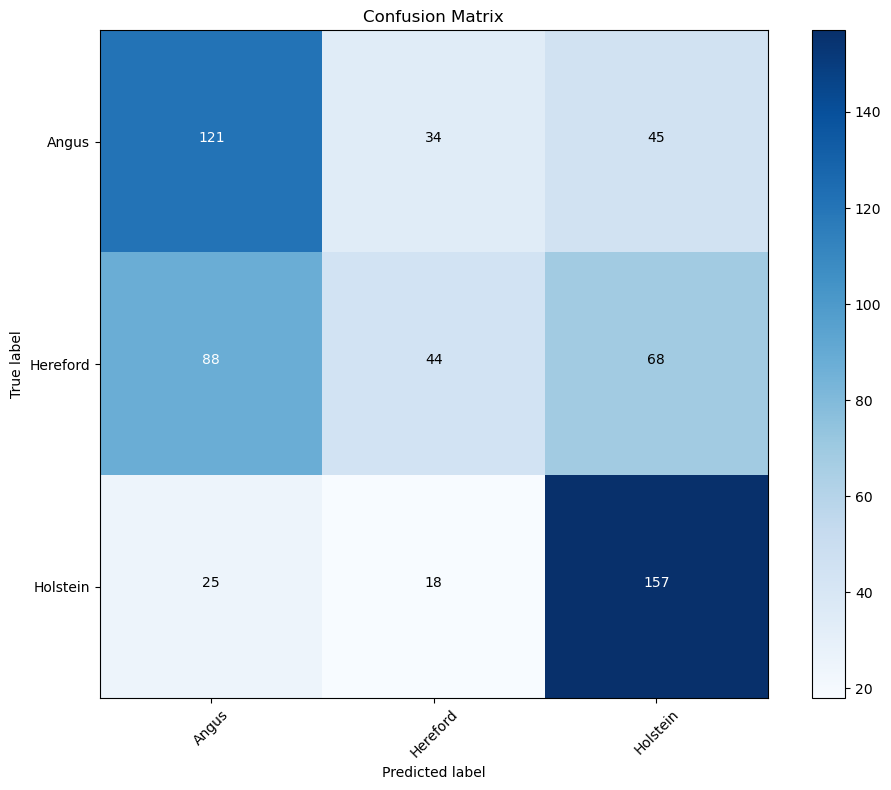


Classification Report:
              precision    recall  f1-score   support

       Angus       0.52      0.60      0.56       200
    Hereford       0.46      0.22      0.30       200
    Holstein       0.58      0.79      0.67       200

    accuracy                           0.54       600
   macro avg       0.52      0.54      0.51       600
weighted avg       0.52      0.54      0.51       600

Mean Average Precision (mAP): 0.1366


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Evaluating MobileNetV3...
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step


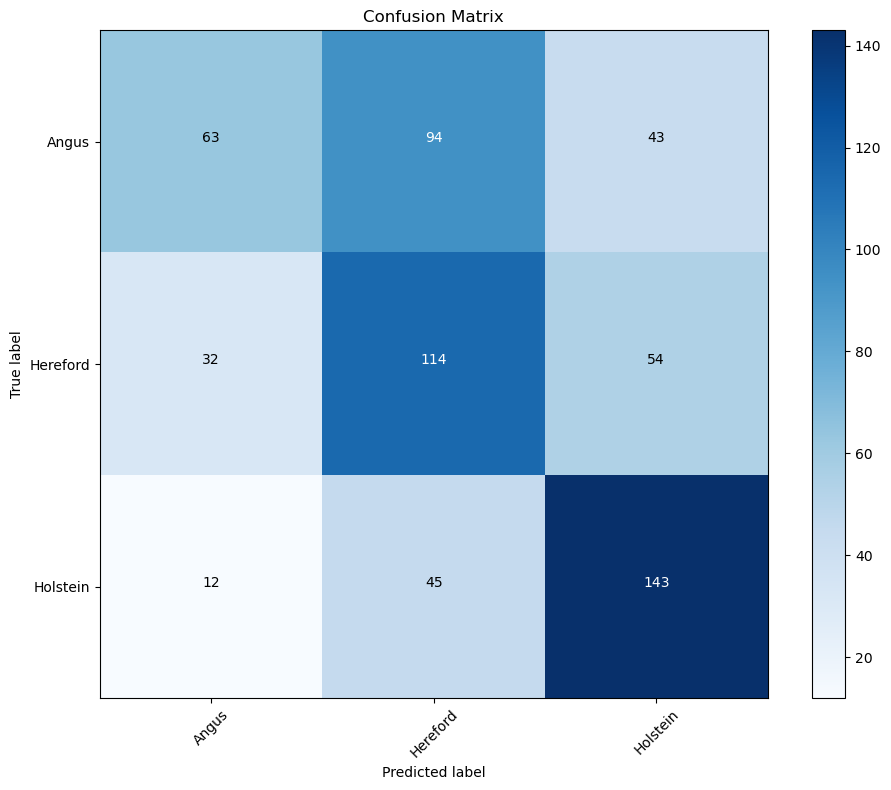


Classification Report:
              precision    recall  f1-score   support

       Angus       0.59      0.32      0.41       200
    Hereford       0.45      0.57      0.50       200
    Holstein       0.60      0.71      0.65       200

    accuracy                           0.53       600
   macro avg       0.55      0.53      0.52       600
weighted avg       0.55      0.53      0.52       600

Mean Average Precision (mAP): 0.1386


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Evaluating DenseNet121...
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


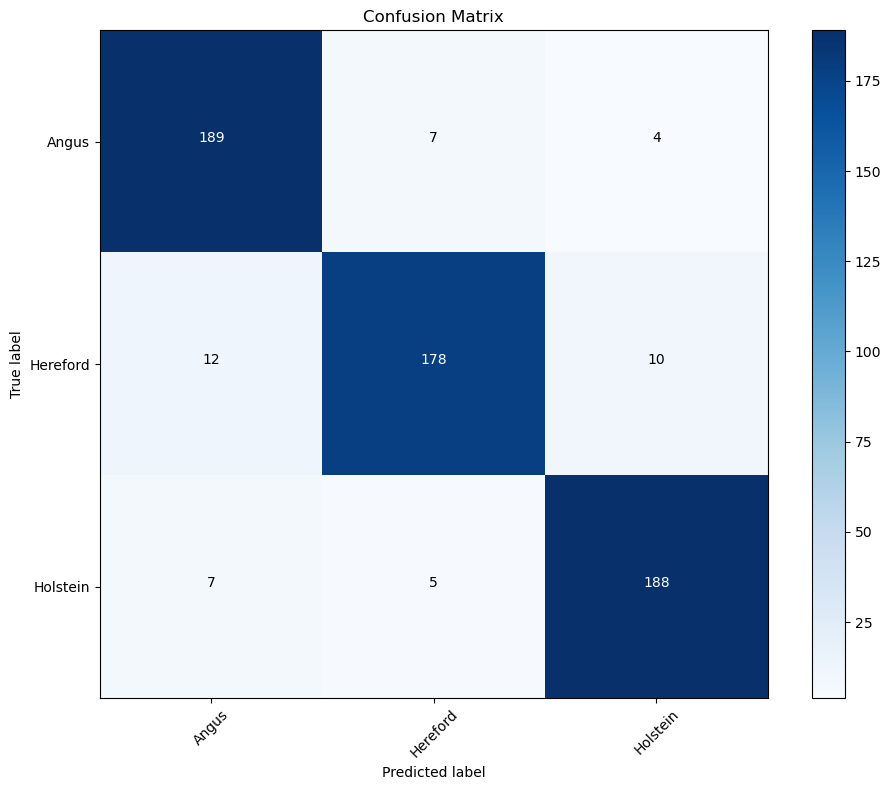


Classification Report:
              precision    recall  f1-score   support

       Angus       0.91      0.94      0.93       200
    Hereford       0.94      0.89      0.91       200
    Holstein       0.93      0.94      0.94       200

    accuracy                           0.93       600
   macro avg       0.93      0.92      0.92       600
weighted avg       0.93      0.93      0.92       600

Mean Average Precision (mAP): 0.2916


In [33]:
def evaluate_model(model, generator, label_encoder, y_true): 
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = y_true  

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    # Add labels
    tick_marks = np.arange(len(label_encoder.classes_))
    plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
    plt.yticks(tick_marks, label_encoder.classes_)

    # Add numbers to confusion matrix
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes,
                              target_names=label_encoder.classes_))

    # Calculate mAP
    mAP = np.mean([
        np.mean(np.array(predictions)[:, i] * (true_classes == i))
        for i in range(len(label_encoder.classes_))
    ])
    print(f"Mean Average Precision (mAP): {mAP:.4f}")

for model_name, file_path in results_files.items():
    # print(file_path)
    if not os.path.exists(file_path):
        print(f"Error: File not found - {file_path}")
        continue
    with open(file_path, 'rb') as f:
        results_data = pickle.load(f)
        
         
    model = results_data.get('model')
    print(f"\nEvaluating {model_name}...")
    evaluate_model(model, test_generator, label_encoder, y_test)